In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, wasserstein_distance
from sklearn.preprocessing import KBinsDiscretizer
from scipy.spatial.distance import cdist, pdist

In [3]:
# Dataset originale (classi sbilanciate, 5 feature)
original = pd.DataFrame({
    'class': [1]*4 + [2]*2 + [4]*3,
    'f1': np.random.rand(9)*100,
    'f2': np.random.rand(9)*100,
    'f3': np.random.rand(9)*100,
    'f4': np.random.rand(9)*100,
    'f5': np.random.rand(9)*100
})
original

,class,f1,f2,f3,f4,f5
0,1,62.147914,91.011345,57.479243,75.219860,3.282397
1,1,91.009684,50.519217,37.342475,7.602331,44.518080
2,1,34.181550,32.413853,91.297979,17.832261,67.915501
3,1,67.891941,61.375861,82.363299,51.785183,94.385102
4,2,97.379013,13.883064,79.744549,52.929184,32.010966
5,2,4.671366,92.676180,76.495230,9.546359,31.113041
6,4,92.068262,51.882789,34.118007,4.986599,90.677006
7,4,21.718207,97.553728,26.715978,74.600880,78.989651
8,4,3.202671,2.102169,33.077646,66.440639,75.440947


In [4]:
class_counts = original['class'].value_counts()
max_count = class_counts.max()
classes_to_augment = class_counts[class_counts < max_count].index.tolist()
print(f"Classe con più tuple: {class_counts.idxmax()} ({max_count} tuple)")
print(f"Classi da aumentare: {classes_to_augment}")

Classe con più tuple: 1 (4 tuple)
Classi da aumentare: [4, 2]


In [2]:
def euclidean_distance_mean(original_class, augmented_class):
    distances = cdist(original_class, augmented_class, metric='euclidean')
    min_distances = np.min(distances, axis=1)
    return np.mean(min_distances)

def kl_divergence_feature(original_class, augmented_class, n_bins=5):
    kl_values = []
    for col in original_class.columns:
        est = KBinsDiscretizer(n_bins=n_bins, encode='onehot-dense', strategy='uniform')
        orig_encoded = est.fit_transform(original_class[[col]])
        aug_encoded = est.transform(augmented_class[[col]])
        orig_prob = orig_encoded.mean(axis=0)
        aug_prob = aug_encoded.mean(axis=0)
        kl = entropy(orig_prob + 1e-10, aug_prob + 1e-10)
        kl_values.append(kl)
    return np.mean(kl_values)

def wasserstein_multifeature(original_class, augmented_class):
    distances = []
    for col in original_class.columns:
        dist = wasserstein_distance(original_class[col], augmented_class[col])
        distances.append(dist)
    return np.mean(distances)

def diversity_augmented(augmented_class):
    distances = pdist(augmented_class, metric='euclidean')
    return np.mean(distances)

In [6]:
# =============================
# 4. Generazione tuple solo per classi con meno tuple
# =============================
augmented_extra = []
for cls in classes_to_augment:
    orig_cls = original[original['class'] == cls]
    n_to_generate = max_count - len(orig_cls)
    for _ in range(n_to_generate):
        # estrai una tupla a caso e aggiungi rumore gaussiano
        new_tuple = orig_cls.sample(1, replace=True).iloc[0, 1:] + np.random.normal(0, 0.2, 5)
        augmented_extra.append([cls] + list(new_tuple))

augmented = pd.concat(
    [original, pd.DataFrame(augmented_extra, columns=original.columns)],
    ignore_index=True
)
augmented

,class,f1,f2,f3,f4,f5
0,1,62.147914,91.011345,57.479243,75.219860,3.282397
1,1,91.009684,50.519217,37.342475,7.602331,44.518080
2,1,34.181550,32.413853,91.297979,17.832261,67.915501
3,1,67.891941,61.375861,82.363299,51.785183,94.385102
4,2,97.379013,13.883064,79.744549,52.929184,32.010966
5,2,4.671366,92.676180,76.495230,9.546359,31.113041
6,4,92.068262,51.882789,34.118007,4.986599,90.677006
7,4,21.718207,97.553728,26.715978,74.600880,78.989651
8,4,3.202671,2.102169,33.077646,66.440639,75.440947
9,4,3.176410,2.073101,32.977972,66.268839,75.136295


In [23]:
original.to_csv("original.csv",sep=",",index=None)
augmented.to_csv("augmented.csv",sep=",",index=None)

In [7]:
results = []
for cls in original['class'].unique():
    orig_cls = original[original['class'] == cls].drop(columns=['class'])
    aug_cls = augmented[augmented['class'] == cls].drop(columns=['class'])
    
    eu_dist = euclidean_distance_mean(orig_cls.values, aug_cls.values)
    kl_div = kl_divergence_feature(orig_cls, aug_cls)
    wass_dist = wasserstein_multifeature(orig_cls, aug_cls)
    diversity = diversity_augmented(aug_cls.values)
    
    results.append({
        'class': cls,
        'original_count': len(orig_cls),
        'augmented_count': len(aug_cls),
        'euclidean_mean': eu_dist,
        'kl_divergence': kl_div,
        'wasserstein': wass_dist,
        'diversity_augmented': diversity
    })

results_df = pd.DataFrame(results)
results_df

,class,original_count,augmented_count,euclidean_mean,kl_divergence,wasserstein,diversity_augmented
0,1,4,4,0.0,0.000000,0.000000,90.346327
1,2,2,4,0.0,0.000000,0.066996,86.154945
2,4,3,4,0.0,0.040929,5.829430,90.973446


## Script per valutare la qualità con i plot 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, wasserstein_distance
from sklearn.metrics import pairwise_distances
import os

def evaluate_quality_with_plots(original_csv, augmented_csv, class_col="class", bins=20, output_dir="plots"):
    """
    Confronta dataset originale e bilanciato calcolando metriche di Fidelity e Diversity
    e produce grafici delle distribuzioni originali vs augmentate per ogni feature e classe.

    Parametri:
    - original_csv: path al dataset sbilanciato (CSV)
    - augmented_csv: path al dataset bilanciato (CSV)
    - class_col: nome della colonna che contiene le etichette di classe
    - bins: numero di bin per stimare le distribuzioni (default=20)
    - output_dir: cartella dove salvare i grafici
    """

    # Caricamento dataset
    original = pd.read_csv(original_csv)
    augmented = pd.read_csv(augmented_csv)

    print(original.shape, augmented.shape)

    # Creazione cartella output
    os.makedirs(output_dir, exist_ok=True)

    results = []
    classes = original[class_col].unique()

    for cls in classes:
        orig_cls = original[original[class_col] == cls].drop(columns=[class_col])
        aug_cls = augmented[augmented[class_col] == cls].drop(columns=[class_col])

        # Fidelity ------------------------
        kl_list = []
        w_list = []
        for col in orig_cls.columns:
            # Costruzione distribuzioni
            p, bins_p = np.histogram(orig_cls[col], bins=bins, density=True)
            q, bins_q = np.histogram(aug_cls[col], bins=bins, density=True)

            # Evita divisioni per zero
            p = p + 1e-10
            q = q + 1e-10

            kl_list.append(entropy(p, q))  
            w_list.append(wasserstein_distance(orig_cls[col], aug_cls[col]))

            # --- Grafico comparativo
            plt.figure(figsize=(6,4))
            plt.hist(orig_cls[col], bins=bins, alpha=0.6, label="Original", density=True)
            plt.hist(aug_cls[col], bins=bins, alpha=0.6, label="Augmented", density=True)
            plt.title(f"Class {cls} - Feature {col}")
            plt.xlabel(col)
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{output_dir}/class{cls}_feature_{col}.png")
            plt.close()

        kl_mean = np.mean(kl_list)
        w_mean = np.mean(w_list)

        # Diversity ------------------------
        if len(aug_cls) > 1:
            dist_matrix = pairwise_distances(aug_cls)
            intra_div = np.mean(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])
        else:
            intra_div = 0.0

        var_mean = aug_cls.var().mean()

        results.append({
            "class": cls,
            "original_count": len(orig_cls),
            "augmented_count": len(aug_cls),
            "KL Divergence ↓": kl_mean,
            "Wasserstein ↓": w_mean,
            "Intra-class Diversity ↑": intra_div,
            "Variance ↑": var_mean
        })

    return pd.DataFrame(results)

In [5]:
original_csv = "original.csv"   # dataset sbilanciato
augmented_csv = "augmented.csv" # dataset bilanciato

results_df = evaluate_quality_with_plots(original_csv, augmented_csv, class_col="class", output_dir="plots_results")
print(results_df.to_string(index=False))
print("\nI grafici sono stati salvati nella cartella 'plots_results'.")

(9, 6) (12, 6)
 class  original_count  augmented_count  KL Divergence ↓  Wasserstein ↓  Intra-class Diversity ↑  Variance ↑
     1               4                4         0.000000       0.000000                90.329372  859.250615
     2               2                4         0.143841       6.785741                32.482108  207.598057
     4               3                4         0.056633       6.144902                81.254180  835.836861

I grafici sono stati salvati nella cartella 'plots_results'.


## Q-function

In [7]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns

def q_function_multi_attributes(data, attributes_A, attributes_B):
    """
    Calculate Q-function for multiple attributes in A and B
    """
    # Creare tuple per A combinando i valori di più attributi
    A_tuples = set()
    B_tuples = set()
    
    for row in data:
        a_tuple = tuple(row[attr] for attr in attributes_A)
        b_tuple = tuple(row[attr] for attr in attributes_B)
        A_tuples.add(a_tuple)
        B_tuples.add(b_tuple)
    
    # Contare le co-occorrenze
    co_occurrences = 0
    for row in data:
        a_tuple = tuple(row[attr] for attr in attributes_A)
        b_tuple = tuple(row[attr] for attr in attributes_B)
        co_occurrences += 1

    print("A_tuples",A_tuples)
    print("a_tuple",a_tuple)
    print("B_tuples",B_tuples)
    print("b_tuple",b_tuple)
    print("co_occurrences",co_occurrences)
    print("len(A_tuples)",len(A_tuples))
    print("len(B_tuples)",len(B_tuples))
    
    # Applicare la formula
    if len(A_tuples) == 0 or len(B_tuples) <= 1: return 0
    else:
        return (co_occurrences - len(A_tuples)) / (len(A_tuples) * (len(B_tuples) - 1))

def q_function_multi_attributes_similarity(data, attributes_A, attributes_B, similarity_threshold):
    """
    Calculate Q-function for multiple attributes in A and B,
    allowing similarity instead of strict equality.
    
    Similarity: absolute difference <= similarity_threshold (element-wise).
    """
    # Creare tuple per A e B
    A_tuples = [tuple(row[attr] for attr in attributes_A) for row in data]
    B_tuples = [tuple(row[attr] for attr in attributes_B) for row in data]
    
    A_set = set(A_tuples)
    B_set = set(B_tuples)
    
    if len(A_set) == 0 or len(B_set) <= 1:
        return 0.0
    
    # Definire la relazione ~T con similarità
    def similar(a, b):
        return all(abs(x - y) <= similarity_threshold for x, y in zip(a, b))
    
    # Costruire insieme {(a,b) | a ∈ A, b ∈ B, a ~ b}
    relation_pairs = set()
    for a in A_set:
        for b in B_set:
            if similar(a, b):
                relation_pairs.add((a, b))
    
    numerator = len(relation_pairs) - len(A_set)
    denominator = len(A_set) * (len(B_set) - 1)
    
    return numerator / denominator if denominator > 0 else 0.0


def load_dataset(file_path: str, format: str = 'csv') -> pd.DataFrame:
    """
    Load dataset from file
    """
    if format.lower() == 'csv':
        return pd.read_csv(file_path)
    elif format.lower() == 'excel':
        return pd.read_excel(file_path)
    elif format.lower() == 'json':
        return pd.read_json(file_path)
    else:
        raise ValueError(f"Unsupported format: {format}")

def calculate_q_scores(data: List[Dict], attribute_groups: List[Tuple[List[str], List[str]]]) -> Dict[str, float]:
    """
    Calculate Q-scores for all attribute group pairs
    """
    q_scores = {}
    
    for i, (attributes_A, attributes_B) in enumerate(attribute_groups):
        group_key = f"Group_{i+1}_{'+'.join(attributes_A)}_vs_{'+'.join(attributes_B)}"
        
        try:
            #q_score = q_function_multi_attributes(data, attributes_A, attributes_B)
            q_score = q_function_multi_attributes_similarity(data, attributes_A, attributes_B, 2)
            q_scores[group_key] = q_score
            
            print(f"{group_key}:")
            print(f"  Attributes A: {attributes_A}")
            print(f"  Attributes B: {attributes_B}")
            print(f"  Q-Score: {q_score:.4f}")
            print()
            
        except Exception as e:
            print(f"Error calculating Q-score for {group_key}: {e}")
            q_scores[group_key] = None
    
    return q_scores

def compare_datasets(original_scores: Dict[str, float], 
                    augmented_scores: Dict[str, float]) -> pd.DataFrame:
    """
    Compare Q-scores between original and augmented datasets
    """
    comparison_data = []
    
    for group_key in original_scores.keys():
        if group_key in augmented_scores:
            original_q = original_scores[group_key]
            augmented_q = augmented_scores[group_key]
            
            if original_q is not None and augmented_q is not None:
                difference = augmented_q - original_q
                relative_change = (difference / original_q * 100) if original_q != 0 else float('inf')
                
                comparison_data.append({
                    'Group': group_key,
                    'Original_Q': original_q,
                    'Augmented_Q': augmented_q,
                    'Difference': difference,
                    'Relative_Change_%': relative_change
                })
    
    return pd.DataFrame(comparison_data)

In [8]:
def plot_q_score_comparison(comparison_df: pd.DataFrame, save_path: str = None):
    """
    Create visualization comparing Q-scores
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Bar chart comparing original vs augmented Q-scores
    ax1 = axes[0, 0]
    x = np.arange(len(comparison_df))
    width = 0.35
    
    ax1.bar(x - width/2, comparison_df['Original_Q'], width, label='Original', alpha=0.8)
    ax1.bar(x + width/2, comparison_df['Augmented_Q'], width, label='Augmented', alpha=0.8)
    ax1.set_xlabel('Attribute Groups')
    ax1.set_ylabel('Q-Score')
    ax1.set_title('Q-Score Comparison: Original vs Augmented')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'G{i+1}' for i in range(len(comparison_df))], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot
    ax2 = axes[0, 1]
    ax2.scatter(comparison_df['Original_Q'], comparison_df['Augmented_Q'], alpha=0.7)
    ax2.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
    ax2.set_xlabel('Original Q-Score')
    ax2.set_ylabel('Augmented Q-Score')
    ax2.set_title('Q-Score Correlation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Difference plot
    ax3 = axes[1, 0]
    bars = ax3.bar(range(len(comparison_df)), comparison_df['Difference'])
    ax3.set_xlabel('Attribute Groups')
    ax3.set_ylabel('Q-Score Difference (Augmented - Original)')
    ax3.set_title('Q-Score Differences')
    ax3.set_xticks(range(len(comparison_df)))
    ax3.set_xticklabels([f'G{i+1}' for i in range(len(comparison_df))], rotation=45)
    ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Color bars based on positive/negative differences
    for i, bar in enumerate(bars):
        if comparison_df.iloc[i]['Difference'] > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
    
    # Plot 4: Relative change plot
    ax4 = axes[1, 1]
    valid_changes = comparison_df[comparison_df['Relative_Change_%'] != float('inf')]['Relative_Change_%']
    valid_indices = comparison_df[comparison_df['Relative_Change_%'] != float('inf')].index
    
    if len(valid_changes) > 0:
        bars4 = ax4.bar(valid_indices, valid_changes)
        ax4.set_xlabel('Attribute Groups')
        ax4.set_ylabel('Relative Change (%)')
        ax4.set_title('Relative Q-Score Changes')
        ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax4.grid(True, alpha=0.3)
        
        for i, bar in enumerate(bars4):
            if valid_changes.iloc[i] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

=== Q-Function Multi-Attribute Analysis ===

Loading datasets...
Original dataset shape: (10, 5)
Augmented dataset shape: (20, 5)

Analyzing 1 valid attribute groups...

=== ORIGINAL DATASET Q-SCORES ===
Group_1_Attr0_vs_Attr1:
  Attributes A: ['Attr0']
  Attributes B: ['Attr1']
  Q-Score: 0.1667


=== AUGMENTED DATASET Q-SCORES ===
Group_1_Attr0_vs_Attr1:
  Attributes A: ['Attr0']
  Attributes B: ['Attr1']
  Q-Score: 0.1231


=== COMPARISON RESULTS ===
                    Group  Original_Q  Augmented_Q  Difference  \
0  Group_1_Attr0_vs_Attr1      0.1667       0.1231     -0.0436   

   Relative_Change_%  
0           -26.1538  

Results saved to: q_function_results.csv
Generating plots...


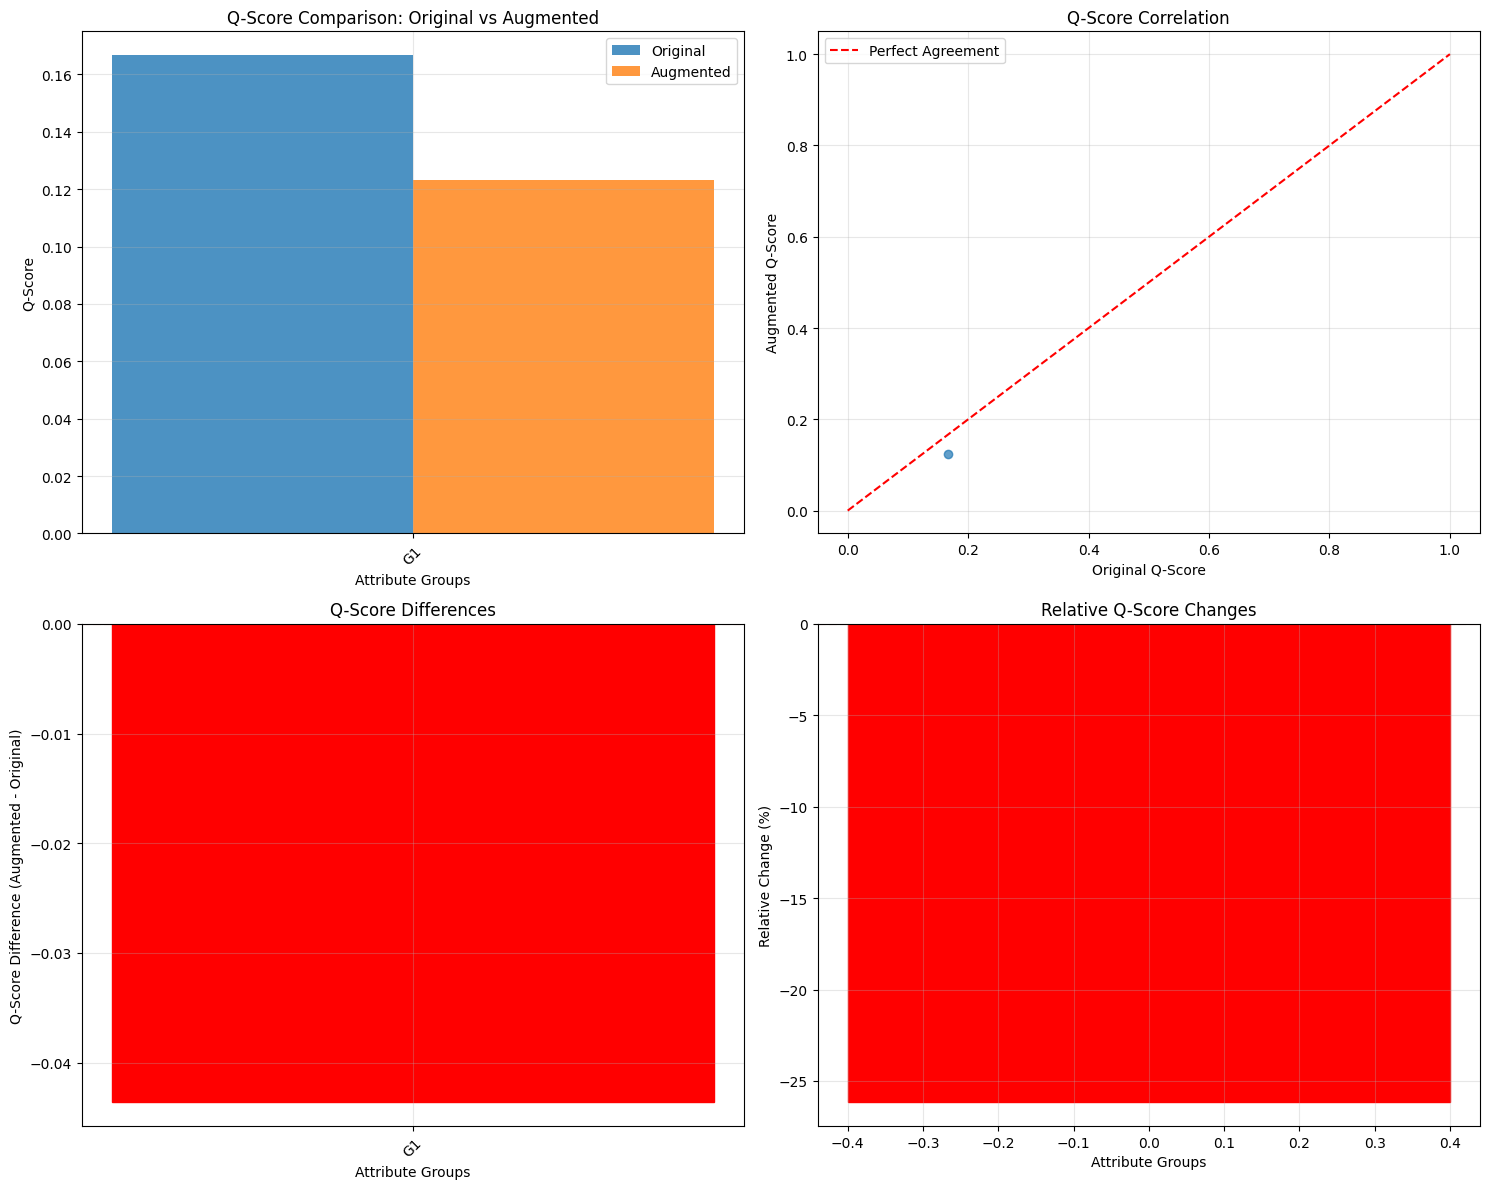


=== SUMMARY STATISTICS ===
Average Q-score (Original): 0.1667
Average Q-score (Augmented): 0.1231
Average Difference: -0.0436

Dependency Preservation:
  Improved (stronger dependencies): 1
  Deteriorated (weaker dependencies): 0
  Unchanged: 0


In [9]:
print("=== Q-Function Multi-Attribute Analysis ===\n")

# Configuration - Modify these paths and parameters
CONFIG = {
    'original_dataset_path': 'dataset_mary/transfusion_min.csv',
    'augmented_dataset_path': 'dataset_mary/transfusion_new_tuples.csv',
    'original_format': 'csv',
    'augmented_format': 'csv',
    'output_file': 'q_function_results.csv',
    'plot_file': 'q_function_comparison.png'
}

# Define attribute groups to analyze
# Each tuple contains (attributes_A, attributes_B)
ATTRIBUTE_GROUPS = [
    (['Attr0'], ['Attr1']),
]

try:
    # Load datasets
    print("Loading datasets...")
    original_df = load_dataset(CONFIG['original_dataset_path'], CONFIG['original_format'])
    augmented_df = load_dataset(CONFIG['augmented_dataset_path'], CONFIG['augmented_format'])
    
    print(f"Original dataset shape: {original_df.shape}")
    print(f"Augmented dataset shape: {augmented_df.shape}")
    print()
    
    # Prepare data for Q-function
    original_data = original_df.to_dict('records')
    augmented_data = augmented_df.to_dict('records')  
    
    # Validate attribute groups against dataset columns
    all_columns = set(original_df.columns)
    valid_groups = []
    
    for i, (attrs_A, attrs_B) in enumerate(ATTRIBUTE_GROUPS):
        missing_attrs = set(attrs_A + attrs_B) - all_columns
        if missing_attrs:
            print(f"Warning: Group {i+1} skipped - missing attributes: {missing_attrs}")
        else:
            valid_groups.append((attrs_A, attrs_B))
    
    if not valid_groups:
        print("Error: No valid attribute groups found!")
    
    print(f"Analyzing {len(valid_groups)} valid attribute groups...\n")
    
    # Calculate Q-scores for original dataset
    print("=== ORIGINAL DATASET Q-SCORES ===")
    original_q_scores = calculate_q_scores(original_data, valid_groups)
    
    print("\n=== AUGMENTED DATASET Q-SCORES ===")
    augmented_q_scores = calculate_q_scores(augmented_data, valid_groups)
    
    # Compare results
    print("\n=== COMPARISON RESULTS ===")
    comparison_df = compare_datasets(original_q_scores, augmented_q_scores)
    
    if not comparison_df.empty:
        print(comparison_df.round(4))
        
        # Save results
        comparison_df.to_csv(CONFIG['output_file'], index=False)
        print(f"\nResults saved to: {CONFIG['output_file']}")
        
        # Create visualizations
        print("Generating plots...")
        plot_q_score_comparison(comparison_df, CONFIG['plot_file'])
        
        # Summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(f"Average Q-score (Original): {comparison_df['Original_Q'].mean():.4f}")
        print(f"Average Q-score (Augmented): {comparison_df['Augmented_Q'].mean():.4f}")
        print(f"Average Difference: {comparison_df['Difference'].mean():.4f}")
        
        # Count improvements vs deteriorations
        improvements = sum(comparison_df['Difference'] < 0)  # Lower Q = stronger dependency = improvement
        deteriorations = sum(comparison_df['Difference'] > 0)
        unchanged = sum(comparison_df['Difference'] == 0)
        
        print(f"\nDependency Preservation:")
        print(f"  Improved (stronger dependencies): {improvements}")
        print(f"  Deteriorated (weaker dependencies): {deteriorations}")
        print(f"  Unchanged: {unchanged}")
    else:
        print("No valid comparisons could be made.")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found - {e}")
    print("Please update the file paths in the CONFIG section.")
except Exception as e:
    print(f"Error during analysis: {e}")